In [3]:
GPU_device_id = str(4)
model_id_save_as = 'caepretrain-full-final'
architecture_id = '../hyperparameter_search/hyperparameter-search-results/CNN-kfoldsfull-final-2-reluupdate_28'
model_class_id = 'CAE'
training_dataset_id = '../dataset_generation/hyperparametersearch_dataset_200keV_full_log10time_1000.npy'
difficulty_setting = 'full'

earlystop_patience = 10
num_epochs = 2000

In [4]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_device_id


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from random import choice

from numpy.random import seed
seed(5)
from tensorflow import set_random_seed
set_random_seed(5)



#### Import model, training function 

In [5]:
from annsa.model_classes import compile_model, f1, build_cae_model, mean_normalized_kl_divergence
from annsa.load_dataset import load_easy, load_full, dataset_to_spectrakeys
from annsa.load_pretrained_network import load_features

Using TensorFlow backend.


## Training Data Construction

In [6]:
training_dataset = np.load(training_dataset_id, allow_pickle=True)
training_source_spectra, training_background_spectra, training_keys = dataset_to_spectrakeys(training_dataset,
                                                                                             sampled=False,
                                                                                             separate_background=True)

## Load Model

In [8]:
model_features = load_features(architecture_id)
model_features.loss = tf.keras.losses.mean_squared_error
model_features.optimizer = tf.keras.optimizers.Adam
model_features.input_dim = 1024

In [9]:
model_features.pool_sizes = model_features.pool_size

cae_features = model_features.to_cae_model_features()
cae_features.metrics = ['mse']

In [10]:
model_features.scaler

Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False, func=<ufunc 'sqrt'>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('normalizer', Normalizer(copy=True, norm='max'))])

## Train network

# Scale input data

In [11]:
training_input = np.random.poisson(training_source_spectra+training_background_spectra)
training_output = training_source_spectra

training_input = cae_features.scaler.transform(training_input)
training_output = cae_features.scaler.transform(training_output)


/home/ubuntu/anaconda3/envs/tensorflow_p36_update/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:161: RuntimeWarning: invalid value encountered in sqrt
  **(kw_args if kw_args else {}))


In [15]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error',
    patience=earlystop_patience,
    mode='min',
    restore_best_weights=True)

csv_logger = tf.keras.callbacks.CSVLogger('./final-models-keras/'+model_id_save_as+'.log')

In [16]:
mlb=LabelBinarizer()
model = compile_model(
            build_cae_model,
            cae_features)

output = model.fit(
    x=training_input,
    y=training_output,
    batch_size=model_features.batch_size,
    validation_split=0.1,
    epochs=500,
    verbose=1,
    shuffle=True,
    callbacks=[earlystop_callback, ],
)


Train on 27000 samples, validate on 3000 samples
Epoch 1/500
27000/27000 [==============================] - 19s 707us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 2/500
27000/27000 [==============================] - 17s 634us/sample - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 3/500
27000/27000 [==============================] - 17s 634us/sample - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 4/500
27000/27000 [==============================] - 17s 635us/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/500
27000/27000 [==============================] - 17s 635us/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 6/500
27000/27000 [==============================] - 17s 635us/sample - loss: 0.0039 

In [17]:
model.save('./final-models-keras/'+model_id_save_as+'.hdf5')

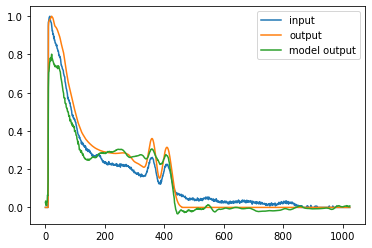

In [32]:
index = 17020

plt.plot(training_input[index:index+1][0], label='input')
plt.plot(training_output[index:index+1][0], label='output')
plt.plot(model.predict(training_input[index:index+1])[0], label='model output')
plt.legend()